### (5/5) Using gaussian pyramid to address spatial variance
* Highest precision: .75 using random forest

In [1]:
import cv2, os
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Adding a modifier to reduce number of dataset
MODIFIER = 4

# Collect the file path of all the running and walking videos, we will only be using these 2 classes
RUN_DIR = "hof/run/"
RUN_FILES = os.listdir(RUN_DIR)
RUN_FILES = [RUN_DIR + f for f in RUN_FILES]
WALK_DIR = "hof/walk/"
WALK_FILES = os.listdir(WALK_DIR)
WALK_FILES = [WALK_DIR + f for f in WALK_FILES]

# Use equal number of data from each class
nc = min(len(RUN_FILES), len(WALK_FILES)) / MODIFIER
print "nc:", nc
RUN_FILES = RUN_FILES[0:nc]
WALK_FILES = WALK_FILES[0:nc]

RATIO = 0.9
offset = int(np.floor(nc*RATIO))
print "offset:", offset

# Split test and training at a ratio of 1:9
train_files = RUN_FILES[0:offset] + WALK_FILES[0:offset]
test_files = RUN_FILES[offset:nc] + WALK_FILES[offset:nc]

# Put the labels in vectors
train_labels = np.zeros(offset*2, int)
train_labels[0:offset] = 1 #RUN=1
train_labels[offset:offset*2] = 2 #WALK=2

test_len = nc-offset
test_labels = np.zeros(test_len*2, int)
test_labels[0:test_len] = 1 #RUN=1
test_labels[test_len:test_len*2] = 2 #WALK=2

print "train files:", len(train_files)
print "train labels:", len(train_labels)
print "test files:", len(test_files)
print "test labels:", len(test_labels)

nc: 58
offset: 52
train files: 104
train labels: 104
test files: 12
test labels: 12


In [3]:
def getPyramid(img, level=5):
    p = []
    p.append(img)
    for i in range(level):
        p.append(cv2.pyrDown(p[len(p)-1]))
    return p

Testing getPyramid()

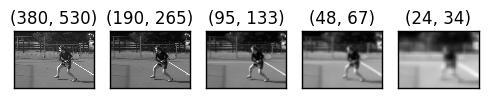

In [4]:
frame1 = cv2.imread("data/tennis492.jpg", 0)
LEVEL = 5

# Getting the pyramid for frame 1
pyramid1 = getPyramid(frame1, LEVEL)

# Printing the pyramid
for i in range(LEVEL):
    img = pyramid1[i]
    plt.subplot(1,LEVEL,i+1)
    plt.title(img.shape)
    plt.xticks([]),plt.yticks([])
    plt.imshow(img, cmap="gray")
plt.show()

In [5]:
from scipy import sqrt, pi, arctan2, cos, sin
from scipy.ndimage import uniform_filter
def hof(flow, orientations=9, pixels_per_cell=(10, 10),
        cells_per_block=(3, 3), visualise=False, normalise=False, motion_threshold=1.):

    """Extract Histogram of Optical Flow (HOF) for a given image.
    Key difference between this and HOG is that flow is MxNx2 instead of MxN
    Compute a Histogram of Optical Flow (HOF) by
        1. (optional) global image normalisation
        2. computing the dense optical flow
        3. computing flow histograms
        4. normalising across blocks
        5. flattening into a feature vector
    Parameters
    ----------
    Flow : (M, N) ndarray
        Input image (x and y flow images).
    orientations : int
        Number of orientation bins.
    pixels_per_cell : 2 tuple (int, int)
        Size (in pixels) of a cell.
    cells_per_block  : 2 tuple (int,int)
        Number of cells in each block.
    visualise : bool, optional
        Also return an image of the hof.
    normalise : bool, optional
        Apply power law compression to normalise the image before
        processing.
    static_threshold : threshold for no motion
    Returns
    -------
    newarr : ndarray
        hof for the image as a 1D (flattened) array.
    hof_image : ndarray (if visualise=True)
        A visualisation of the hof image.
    References
    ----------
    * http://en.wikipedia.org/wiki/Histogram_of_oriented_gradients
    * Dalal, N and Triggs, B, Histograms of Oriented Gradients for
      Human Detection, IEEE Computer Society Conference on Computer
      Vision and Pattern Recognition 2005 San Diego, CA, USA
    """
    flow = np.atleast_2d(flow)

    """ 
    -1-
    The first stage applies an optional global image normalisation
    equalisation that is designed to reduce the influence of illumination
    effects. In practice we use gamma (power law) compression, either
    computing the square root or the log of each colour channel.
    Image texture strength is typically proportional to the local surface
    illumination so this compression helps to reduce the effects of local
    shadowing and illumination variations.
    """

    if flow.ndim < 3:
        raise ValueError("Requires dense flow in both directions")

    if normalise:
        flow = sqrt(flow)

    """ 
    -2-
    The second stage computes first order image gradients. These capture
    contour, silhouette and some texture information, while providing
    further resistance to illumination variations. The locally dominant
    colour channel is used, which provides colour invariance to a large
    extent. Variant methods may also include second order image derivatives,
    which act as primitive bar detectors - a useful feature for capturing,
    e.g. bar like structures in bicycles and limbs in humans.
    """

    if flow.dtype.kind == 'u':
        # convert uint image to float
        # to avoid problems with subtracting unsigned numbers in np.diff()
        flow = flow.astype('float')

    gx = np.zeros(flow.shape[:2])
    gy = np.zeros(flow.shape[:2])
    # gx[:, :-1] = np.diff(flow[:,:,1], n=1, axis=1)
    # gy[:-1, :] = np.diff(flow[:,:,0], n=1, axis=0)

    gx = flow[:,:,1]
    gy = flow[:,:,0]



    """ 
    -3-
    The third stage aims to produce an encoding that is sensitive to
    local image content while remaining resistant to small changes in
    pose or appearance. The adopted method pools gradient orientation
    information locally in the same way as the SIFT [Lowe 2004]
    feature. The image window is divided into small spatial regions,
    called "cells". For each cell we accumulate a local 1-D histogram
    of gradient or edge orientations over all the pixels in the
    cell. This combined cell-level 1-D histogram forms the basic
    "orientation histogram" representation. Each orientation histogram
    divides the gradient angle range into a fixed number of
    predetermined bins. The gradient magnitudes of the pixels in the
    cell are used to vote into the orientation histogram.
    """

    magnitude = sqrt(gx**2 + gy**2)
    orientation = arctan2(gy, gx) * (180 / pi) % 180

    sy, sx = flow.shape[:2]
    cx, cy = pixels_per_cell
    bx, by = cells_per_block

    n_cellsx = int(np.floor(sx // cx))  # number of cells in x
    n_cellsy = int(np.floor(sy // cy))  # number of cells in y

    # compute orientations integral images
    orientation_histogram = np.zeros((n_cellsy, n_cellsx, orientations))
    subsample = np.index_exp[cy / 2:cy * n_cellsy:cy, cx / 2:cx * n_cellsx:cx]
    for i in range(orientations-1):
        #create new integral image for this orientation
        # isolate orientations in this range

        temp_ori = np.where(orientation < 180 / orientations * (i + 1),
                            orientation, -1)
        temp_ori = np.where(orientation >= 180 / orientations * i,
                            temp_ori, -1)
        # select magnitudes for those orientations
        cond2 = (temp_ori > -1) * (magnitude > motion_threshold)
        temp_mag = np.where(cond2, magnitude, 0)

        temp_filt = uniform_filter(temp_mag, size=(cy, cx))
        orientation_histogram[:, :, i] = temp_filt[subsample]

    ''' Calculate the no-motion bin '''
    temp_mag = np.where(magnitude <= motion_threshold, magnitude, 0)

    temp_filt = uniform_filter(temp_mag, size=(cy, cx))
    orientation_histogram[:, :, -1] = temp_filt[subsample]

    # now for each cell, compute the histogram
    hof_image = None

    if visualise:
        from skimage import draw

        radius = min(cx, cy) // 2 - 1
        hof_image = np.zeros((sy, sx), dtype=float)
        for x in range(n_cellsx):
            for y in range(n_cellsy):
                for o in range(orientations-1):
                    centre = tuple([y * cy + cy // 2, x * cx + cx // 2])
                    dx = int(radius * cos(float(o) / orientations * np.pi))
                    dy = int(radius * sin(float(o) / orientations * np.pi))
                    rr, cc = draw.bresenham(centre[0] - dy, centre[1] - dx,
                                            centre[0] + dy, centre[1] + dx)
                    hof_image[rr, cc] += orientation_histogram[y, x, o]

    """
    The fourth stage computes normalisation, which takes local groups of
    cells and contrast normalises their overall responses before passing
    to next stage. Normalisation introduces better invariance to illumination,
    shadowing, and edge contrast. It is performed by accumulating a measure
    of local histogram "energy" over local groups of cells that we call
    "blocks". The result is used to normalise each cell in the block.
    Typically each individual cell is shared between several blocks, but
    its normalisations are block dependent and thus different. The cell
    thus appears several times in the final output vector with different
    normalisations. This may seem redundant but it improves the performance.
    We refer to the normalised block descriptors as Histogram of Oriented
    Gradient (hog) descriptors.
    """

    n_blocksx = (n_cellsx - bx) + 1
    n_blocksy = (n_cellsy - by) + 1
    normalised_blocks = np.zeros((n_blocksy, n_blocksx,
                                  by, bx, orientations))

    for x in range(n_blocksx):
        for y in range(n_blocksy):
            block = orientation_histogram[y:y+by, x:x+bx, :]
            eps = 1e-5
            normalised_blocks[y, x, :] = block / sqrt(block.sum()**2 + eps)

    """
    The final step collects the hof descriptors from all blocks of a dense
    overlapping grid of blocks covering the detection window into a combined
    feature vector for use in the window classifier.
    """

    if visualise:
        return normalised_blocks.ravel(), hof_image
    else:
        return normalised_blocks.ravel()

In [6]:
def getOpticalFlow(imPrev, imNew):
    flow = cv2.calcOpticalFlowFarneback(imPrev, imNew, flow=None, pyr_scale=.5, levels=3, winsize=9, iterations=1, poly_n=3, poly_sigma=1.1, flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
    return flow

In [7]:
frame2 = cv2.imread("data/tennis493.jpg", 0)
pyramid2 = getPyramid(frame2, LEVEL)

In [8]:
flow_level_0 = getOpticalFlow(pyramid1[0], pyramid2[0])
hoof_level_0 = hof(flow_level_0)
print hoof_level_0.shape

(148716,)


# Result

In [9]:
def getOpticalFlow(imPrev, imNew):
    flow = cv2.calcOpticalFlowFarneback(imPrev, imNew, flow=None, pyr_scale=.5, levels=3, winsize=9, iterations=1, poly_n=3, poly_sigma=1.1, flags=cv2.OPTFLOW_FARNEBACK_GAUSSIAN)
    return flow

def getPyramid(img, level):
    p = []
    p.append(img)
    for i in range(level):
        p.append(cv2.pyrDown(p[len(p)-1]))
    return p

def getPyramidHof(frame1, frame2, level, getHofFunc, getPyramidFunc, getOpticalFlowFunc):
    if frame1.shape != frame2.shape:
        raise ValueError('frame1 and frame2 should have identical dimensions')
    pyramid1 = getPyramidFunc(frame1, level)
    pyramid2 = getPyramidFunc(frame2, level)
    pyramidHoF = []
    for i in range(level):
        subframe1 = pyramid1[i]
        subframe2 = pyramid2[i]
        subflow = getOpticalFlowFunc(subframe1, subframe2)
        subhof = getHofFunc(subflow)
        pyramidHoF = np.append(pyramidHoF, subhof)
    return pyramidHoF

In [10]:
DEFAULT_SIZE = 128
frame1_resized = cv2.resize(frame1, (DEFAULT_SIZE,DEFAULT_SIZE))
frame2_resized = cv2.resize(frame2, (DEFAULT_SIZE,DEFAULT_SIZE))

pyramid_hof = getPyramidHof(frame1_resized, frame2_resized, 3, hof, getPyramid, getOpticalFlow)
pyramid_hof.shape

(9477,)

In [11]:
FIXED_WIDTH = 128
FIXED_HEIGHT = 128
def normalizeFrame(frame_original):
    frame_gray = cv2.cvtColor(frame_original,cv2.COLOR_BGR2GRAY)
    frame_gray_resized = cv2.resize(frame_gray, (FIXED_WIDTH, FIXED_HEIGHT))
    return frame_gray_resized

def getPyramidHofFromVid(video_path, level, normalizeFrameFunc=normalizeFrame, getHofFunc=hof, getPyramidFunc=getPyramid, getOpticalFlowFunc=getOpticalFlow):
    print "Processing", video_path
    cap = cv2.VideoCapture(video_path)
    vid_hof = []
    ret1, frame1 = cap.read()
    frame1 = normalizeFrameFunc(frame1)
    while(cap.isOpened()):
        ret2, frame2 = cap.read()
        if ret2 == True:
            frame2 = normalizeFrameFunc(frame2)
            biframe_hof = getPyramidHof(frame1, frame2, level, getHofFunc, getPyramidFunc, getOpticalFlowFunc)
            vid_hof = np.append(vid_hof, biframe_hof)
            frame1 = frame2
        else:
            break
    cap.release()
    return vid_hof

In [12]:
sample_video_path = RUN_FILES[0]
print sample_video_path

cap = cv2.VideoCapture(sample_video_path)
length = int(cap.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT))
cap.release()
print "# of frames =", length

hof/run/20060723sfjffangelina_run_f_cm_np2_fr_med_3.avi
# of frames = 23


### Calculate the time it takes to generate hof from a single video

In [13]:
%%time 
vid_hof = getPyramidHofFromVid(sample_video_path, 3)

Processing hof/run/20060723sfjffangelina_run_f_cm_np2_fr_med_3.avi
CPU times: user 296 ms, sys: 21.4 ms, total: 317 ms
Wall time: 332 ms


In [14]:
vid_hof.shape

(199017,)

In [15]:
%%time
LEVEL = 3
train = [getPyramidHofFromVid(p, LEVEL) for p in train_files]
test = [getPyramidHofFromVid(p, LEVEL) for p in test_files]

Processing hof/run/20060723sfjffangelina_run_f_cm_np2_fr_med_3.avi
Processing hof/run/20060723sfjffangelina_run_f_nm_np1_ri_med_1.avi
Processing hof/run/20060723sfjffangelina_run_f_nm_np1_ri_med_2.avi
Processing hof/run/20060723sfjffbartsinger_run_f_nm_np1_fr_med_1.avi
Processing hof/run/20060723sfjffbumblebeesuitman_run_f_cm_np2_ri_med_1.avi
Processing hof/run/20060723sfjffinallseriousness_run_f_cm_np1_fr_med_0.avi
Processing hof/run/20060723sfjffinallseriousness_run_f_cm_np2_ba_med_2.avi
Processing hof/run/20060723sfjffinallseriousness_run_u_cm_np1_fr_med_1.avi
Processing hof/run/20060723sfjffjewcy_run_f_nm_np1_ba_med_3.avi
Processing hof/run/20060723sfjffsomelikeitwarmed_run_f_nm_np1_fr_med_6.avi
Processing hof/run/50_FIRST_DATES_run_f_cm_np1_ba_med_12.avi
Processing hof/run/50_FIRST_DATES_run_f_cm_np1_ri_med_21.avi
Processing hof/run/50_FIRST_DATES_run_f_nm_np1_ba_med_20.avi
Processing hof/run/50_FIRST_DATES_run_f_nm_np1_fr_med_34.avi
Processing hof/run/A_Beautiful_Mind_4_run_f_cm_

Pad training and testing sets by 0

In [16]:
print len(test[1])
print len(test[2])
max_width = max(np.array([len(i) for i in train]).max(),np.array([len(i) for i in test]).max())
def numpy_fillna(data, width):
    # Get lengths of each row of data
    lens = np.array([len(i) for i in data])

    # Mask of valid places in each row
    mask = np.arange(width) < lens[:,None]

    # Setup output array and put elements from data into masked positions
    out = np.zeros(mask.shape, dtype=data.dtype)
    out[mask] = np.concatenate(data)
    return out
train_pad = numpy_fillna(np.array(train), max_width)
test_pad = numpy_fillna(np.array(test), max_width)

957177
777114


In [17]:
%%time
from sklearn import svm, metrics

clf = svm.SVC()
clf.fit(train_pad, train_labels)
predict = clf.predict(test_pad)
print metrics.accuracy_score(predict, test_labels)

0.583333333333
CPU times: user 36.9 s, sys: 4.88 s, total: 41.8 s
Wall time: 43.2 s


In [18]:
%%time
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf.fit(train_pad, train_labels)
predict = clf.predict(test_pad)
print metrics.accuracy_score(predict, test_labels)

0.416666666667
CPU times: user 23.5 s, sys: 2.56 s, total: 26.1 s
Wall time: 26.1 s


In [19]:
%%time
from sklearn import ensemble
clf = ensemble.RandomForestClassifier()
clf.fit(train_pad, train_labels)
predict = clf.predict(test_pad)
print metrics.accuracy_score(predict, test_labels)

0.75
CPU times: user 5.79 s, sys: 465 ms, total: 6.26 s
Wall time: 6.27 s


In [20]:
%%time
from sklearn import linear_model
clf = linear_model.LogisticRegression()
clf.fit(train_pad, train_labels)
predict = clf.predict(test_pad)
print metrics.accuracy_score(predict, test_labels)

0.5
CPU times: user 15.3 s, sys: 2.19 s, total: 17.4 s
Wall time: 17.9 s
